# Simple vs Log Returns and Normality Assumption
## Takao Oba
#### Assisted by quantpy

#### What is the difference between simple returns and log returns?

#### Simple returns: The product of normally distributed variables is NOT normally distributed
#### Log returns: The sum of normally distributed variables DOES follow a normal distribution

In [1]:
# Importing dependencies

import datetime as dt
import pandas as pd
import numpy as np
import pylab
import seaborn as sns
import scipy.stats as stats
from pandas_datareader import data as pdr
import plotly.offline as pyo

pyo.init_notebook_mode(connected = True)
pd.options.plotting.backend = 'plotly'

In [2]:
# Getting the stock market data
end = dt.datetime.now()
start = dt.datetime(2018,1,1)


import yfinance as yfin
yfin.pdr_override()
df = pdr.get_data_yahoo('AAPL', start, end)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.950489,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.943363,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.133553,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.601868,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.447338,82271200


## Simple Return

#### The formula for simple return is: 
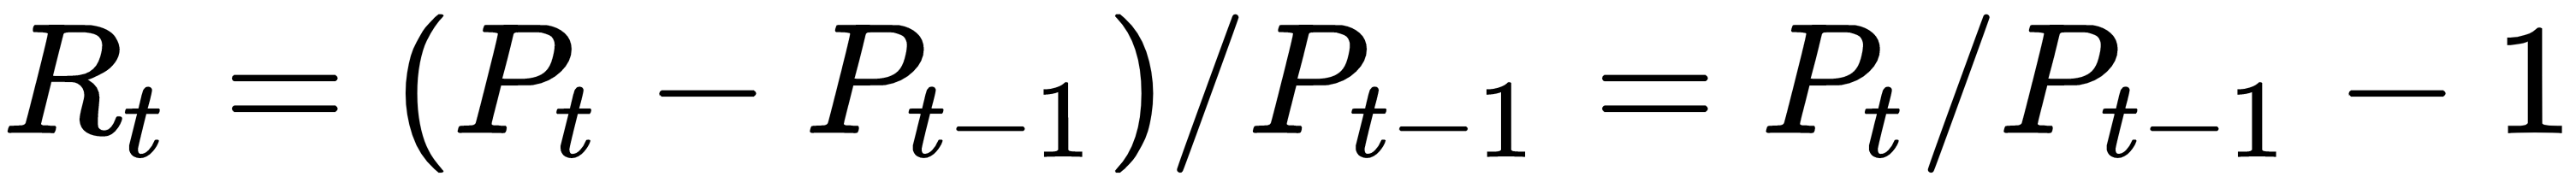

###### Image from https://subscription.packtpub.com/book/data/9781789618518/1/ch01lvl1sec05/converting-prices-to-returns

In [3]:
# Calculating daily simple returns

simple_returns = df.Close.pct_change().dropna()
simple_returns

Date
2018-01-03   -0.000174
2018-01-04    0.004645
2018-01-05    0.011385
2018-01-08   -0.003714
2018-01-09   -0.000115
                ...   
2022-12-23   -0.002798
2022-12-27   -0.013878
2022-12-28   -0.030685
2022-12-29    0.028324
2022-12-30    0.002469
Name: Close, Length: 1258, dtype: float64

In [4]:
# Plotting financial data and look at first and last share prices
df.Close.plot().update_layout(autosize = False, width = 500, height = 300)

In [5]:
print('First', df.Close[0], 'Last', df.Close[-1])

First 43.064998626708984 Last 129.92999267578125


In [6]:
# Use simple returns & attempt to compute the final price from starting price over time horizon

simple_returns.mean()

0.001100790011248004

In [7]:
df.Close[0]*(1+simple_returns.mean())**len(simple_returns) # Not close as last value

171.8707566899991

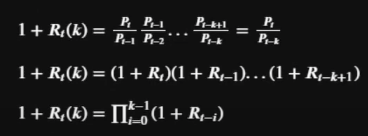

In [8]:
# Using formula above, we have that:
df.Close[0]*np.prod([(1+Rt) for Rt in simple_returns]) # Very close last value

129.92999267578165

#### Simple return is not easy to compute, cannot point to the mean, doesn't desribe a lot by itself. Look into alternative methods

## Log Returns:

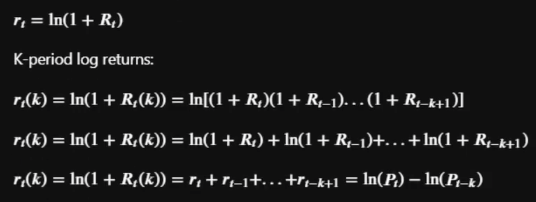

In [9]:
# Computing log returns:
log_returns = np.log(df.Close/df.Close.shift(1))
log_returns

Date
2018-01-02         NaN
2018-01-03   -0.000174
2018-01-04    0.004634
2018-01-05    0.011321
2018-01-08   -0.003721
                ...   
2022-12-23   -0.002802
2022-12-27   -0.013976
2022-12-28   -0.031166
2022-12-29    0.027931
2022-12-30    0.002466
Name: Close, Length: 1259, dtype: float64

In [10]:
# drop nas
log_returns = np.log(df.Close/df.Close.shift(1)).dropna()
log_returns

Date
2018-01-03   -0.000174
2018-01-04    0.004634
2018-01-05    0.011321
2018-01-08   -0.003721
2018-01-09   -0.000115
                ...   
2022-12-23   -0.002802
2022-12-27   -0.013976
2022-12-28   -0.031166
2022-12-29    0.027931
2022-12-30    0.002466
Name: Close, Length: 1258, dtype: float64

In [11]:
log_returns.mean()

0.0008778101885308492

In [12]:
df.Close[0] * np.exp(log_returns.mean() * len(log_returns)) 
# Calculated end value accurately

129.9299926757816

 #### Look further into log returns. Note that the log distribution bounds the stock price at 0 which is consistent with reality.

In [13]:
# histogram of log returns

log_returns.plot(kind = 'hist').update_layout(autosize = False, width = 500, height = 300)

In [14]:
# Is this log return normally distributed
log_returns_sorted = log_returns.tolist()
log_returns_sorted.sort()
log_returns_sorted

# since this is sorted from least to greates, the following holds
worst = log_returns_sorted[0]
best = log_returns_sorted[-1]

# std of worst and best
std_worst = (worst - log_returns.mean())/log_returns.std()
std_best = (best - log_returns.mean())/log_returns.std()

print('Standard dev. worst %.2f best %.2f' %(std_worst, std_best))
# This is a very big standard deviation considering normal distribution

# Find the probability of achieving these values
print('Probability worst %.11f best %.11f' %(stats.norm(0,1).pdf(std_worst), stats.norm(0,1).pdf(std_best)))

Standard dev. worst -6.56 best 5.32
Probability worst 0.00000000018 best 0.00000028801


## Testing for normality of financial data

### Quantile-Quantile Plots
##### This plots two sets of quantiles against one another i.e. theoretical quanties against the actual quantiles of the variable

Q-Q Plot


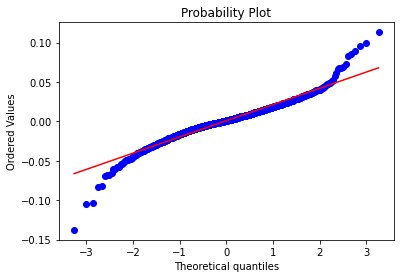

In [15]:
stats.probplot(log_returns, dist = 'norm', plot = pylab)

print('Q-Q Plot') # Starts deviating from normally distributed line if goes away from center

In [16]:
# It may not be best to use normal distribution to map full financial data
# Can be sufficient for middle data

### Box Plots
##### Box plot also known as a box and whisker plot is another way to visualize the normality of a variable. it displays the distribution of data based on five-number summary i.e. minimum, first quartile (Q1), median (Q2), third quartile (Q3), and maximum

In [17]:
log_returns.plot(kind = 'box').update_layout(autosize = False, width = 500, height = 300)
# There is a very heavy tail, many outliers

### From the two plots above, normal distribution might not best represent the full financial data for AAPL

## Hypothesis Testing/Statistical Inference
##### This method can give a more objective answer

### Kolmogorov Smirnov test
##### The Kolmogorov Smirnov test computes the distance between the empirical distances and the theoretical distribution and defines the test statistic as the suprenum of the set of those distances. The Test Statistic of the KS Test is the Kolmogorov Smirnov Statistic, which follows a Kolmogorov distribution is the null hypothesis is true. If the observed data perfectly follows a normal distribution, the value of the KS statistic will be 0. The P-Value is used to decide whether the difference is large enough to reject the null hypothesis
##### The advantage of this method is that the same approach can be used for comparing any distribution, not necessary just the normal distribution

In [18]:
ks_stat, p_value = stats.kstest(log_returns, 'norm')
print(ks_stat, p_value)


if p_value > 0.05:
    print("Probability Guassian") # normally distributed with this CI
else: 
    print("Probability Not Guassian")

0.4687506939095014 5.7109740782936125e-254
Probability Not Guassian


### Shapiro Wilk Test
##### The Shapiro Wilk test is the most powerful test when testing for a normal distribution. It has been developed specifically for the normal distribution and it cannot be used for testing against other distributions like for example the KS Test

In [19]:
sw_stat, p_value = stats.shapiro(log_returns)
print(sw_stat, p_value)


if p_value > 0.05:
    print("Probability Guassian") # normally distributed with this CI
else: 
    print("Probability Not Guassian")

0.9487610459327698 1.640752811559851e-20
Probability Not Guassian


In [25]:
# For a tighter time frame
start = dt.datetime(2022,6,1)
df = pdr.get_data_yahoo('AAPL', start, end)
log_returns = np.log(df.Close/df.Close.shift(1)).dropna()
sw_stat, p_value = stats.shapiro(log_returns)
print(sw_stat, p_value)


if p_value > 0.05:
    print("Probability Guassian") # normally distributed with this CI
else: 
    print("Probability Not Guassian")

[*********************100%***********************]  1 of 1 completed
0.9821842908859253 0.053514380007982254
Probability Guassian


##### We can see that when tightening the time frame, the financial data does follow a normal distribution

# In conclusion, I have looked into simple return and log return and assessed how log returns are generally more useful as they are additive. Further, I assessed the normality assumptions of this financial data to see if further analysis can be made. I have done this through visual and quantitative analysis. I have generated two plots to visually represent if the data is normally distributed and further looked into two types of hypothesis tests. 
